In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = 0.5,
        m_rate = 0.6,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.5,
        grow_factor = 0.5,
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8209876543209876, Loss: 0.7486291814733435
Checkpoint 200, Accuracy: 0.8271604938271605, Loss: 0.6974923169171369
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.6943651128698278
Checkpoint 400, Accuracy: 0.8333333333333334, Loss: 0.6862652390091507
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.6870334060103805


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

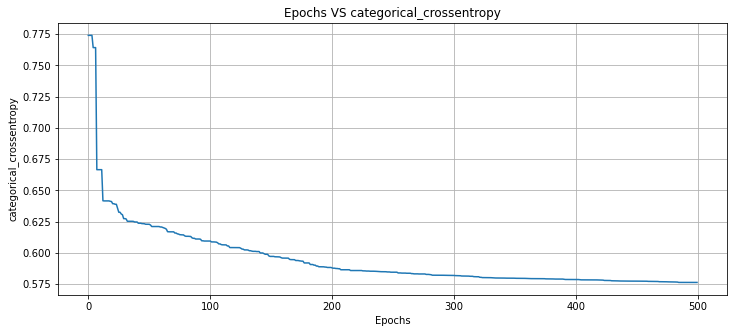

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [[0.09825618]
 [0.427512  ]
 [0.4742318 ]]
[1. 0. 0.] <-> [[0.8371195 ]
 [0.09485341]
 [0.06802706]]
[0. 0. 1.] <-> [[0.21935375]
 [0.4082079 ]
 [0.3724383 ]]
[0. 0. 1.] <-> [[0.95989734]
 [0.0224282 ]
 [0.01767438]]
[1. 0. 0.] <-> [[0.94674855]
 [0.02873567]
 [0.02451575]]
[1. 0. 0.] <-> [[0.91540277]
 [0.04362668]
 [0.04097063]]
[1. 0. 0.] <-> [[0.95514536]
 [0.0247114 ]
 [0.02014326]]
[0. 0. 1.] <-> [[0.66047996]
 [0.23676229]
 [0.10275771]]
[1. 0. 0.] <-> [[0.4206028 ]
 [0.32351422]
 [0.25588304]]
[1. 0. 0.] <-> [[0.2041095 ]
 [0.41317812]
 [0.38271245]]
[0. 0. 1.] <-> [[0.9565961 ]
 [0.02401463]
 [0.01938924]]
[1. 0. 0.] <-> [[0.9573452 ]
 [0.02365478]
 [0.01900006]]
[0. 1. 0.] <-> [[0.55731857]
 [0.32195386]
 [0.12072757]]
[0. 1. 0.] <-> [[0.10516023]
 [0.428623  ]
 [0.4662168 ]]
[1. 0. 0.] <-> [[0.37142882]
 [0.34570825]
 [0.28286296]]
[0. 1. 0.] <-> [[0.52395   ]
 [0.33755696]
 [0.13849309]]
[1. 0. 0.] <-> [[0.9651791 ]
 [0.0198902 ]
 [0.01493062]]
[1. 0. 0.] <->

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8209876543209876, 'mean_square_error': 2.915347882836357, 'categorical_crossentropy': 0.7486291814733435, 'precision': 0.7314814814814815, 'recall': 0.7314814814814815, 'f1': 0.7314814814814816, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 4}, 1: {'tp_hit': 7, 'fp_hit': 14, 'tn_hit': 77, 'fn_hit': 10}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}}, 'checkpoint': 100} 


{'accuracy': 0.8271604938271605, 'mean_square_error': 2.9100376002771267, 'categorical_crossentropy': 0.6974923169171369, 'precision': 0.7407407407407407, 'recall': 0.7407407407407407, 'f1': 0.7407407407407407, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 5}, 1: {'tp_hit': 5, 'fp_hit': 11, 'tn_hit': 80, 'fn_hit': 12}, 2: {'tp_hit': 4, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.9155522485238725, 'categorical_crossentropy': 0.6943651128698278, 'precisio

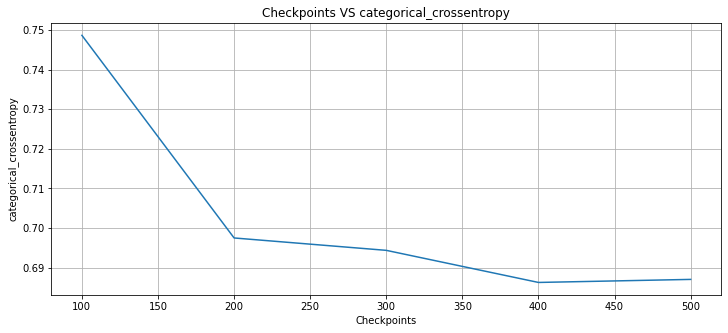

In [16]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

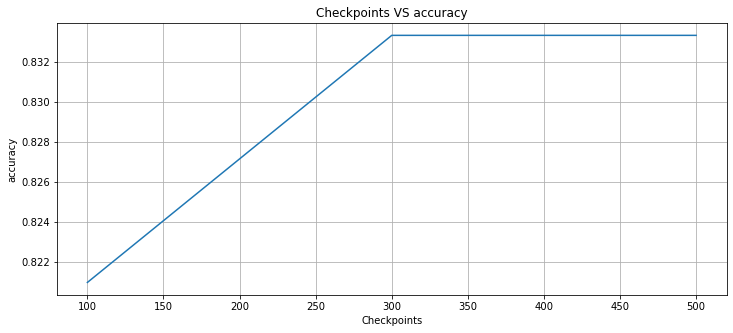

In [17]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [18]:
print(model)

Layer 1
Neuron 0: weights:
[[-0.53327423]
 [-0.3117795 ]
 [-1.7331065 ]
 [ 2.2924156 ]
 [ 1.0875566 ]]
 bias: [-0.89072996]

Neuron 1: weights:
[[ 2.629629  ]
 [-0.9903834 ]
 [-0.36637518]
 [ 1.4765925 ]
 [-2.3725204 ]]
 bias: [-0.79507124]

Neuron 2: weights:
[[-2.8707166]
 [-2.9602945]
 [-3.       ]
 [-3.       ]
 [-2.6371346]]
 bias: [-0.72897005]

Neuron 3: weights:
[[0.7276437]
 [1.4273999]
 [2.663803 ]
 [1.5369706]
 [1.5002084]]
 bias: [-2.810584]

$
Layer 2
Neuron 0: weights:
[[-3.       ]
 [-3.       ]
 [ 2.7085824]
 [-0.747822 ]]
 bias: [1.6948093]

Neuron 1: weights:
[[ 0.60179573]
 [-1.1065013 ]
 [ 0.39614788]
 [-1.3987198 ]]
 bias: [-0.35136127]

Neuron 2: weights:
[[ 0.08322325]
 [ 1.4108795 ]
 [ 1.5907823 ]
 [-0.53771126]]
 bias: [-2.184252]

$

